# Calculate heatwave duration within data

In [1]:
import iris
import pandas as pd
import xarray as xr
import numpy as np
from dask import array as da

In [2]:
def np_consecutive(arr):
    if isinstance(arr, (xr.DataArray, iris.cube.Cube)):
        data = arr.data
        if isinstance(data, da.Array):
            data.compute_chunk_sizes()
    else:
        data = arr
    out = np.diff(np.where(np.concatenate(([data[0]],
                                     data[:-1] != data[1:],
                                     [True])))[0])[::2]
    return out

In [194]:
def consec_count(data, threshold=25, ndays=14):
    
    days = np.arange(0, ndays+1)
    heatwave_counts = {}
    years = np.unique(data.year)
    for year in years:
        counts = np.zeros_like(days)
        arr = data[data.year==year]
        arr_hot = arr>threshold
        hots = np_consecutive(arr_hot)
        colds = np.count_nonzero(~arr_hot)
        counts[0]=colds
        for day in days[1:-1]:
            counts[day]=np.count_nonzero(hots==day)
        counts[-1]=np.count_nonzero(hots>=days[-1])

        heatwave_counts[year]=counts
    return heatwave_counts

In [7]:
def annual_heatwaves(data, **kwargs):
    if isinstance(data, iris.cube.Cube):
        data = xr.DataArray.from_iris(data).compute()
    ensemble = np.unique(data.ensemble_member)
    dfs = []
    for member in ensemble:
        arr = data.sel(ensemble_member=member).compute()
        counts = consec_count(arr, **kwargs)
        df = pd.DataFrame.from_dict(counts, orient='index')
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'year'}, inplace=True)
        df['ensemble_member']=member
        dfs.append(df)
    return pd.concat(dfs)

## `tasmax`

In [5]:
%%time
fname = "data/UKCP/utci_regional/tasmax_rcp85_land-cpm_uk_london_01-15_day_19801201-20801130.nc"
tasmax = iris.load_cube(fname)
tasmax.summary(shorten=True)

CPU times: user 298 ms, sys: 24.9 ms, total: 323 ms
Wall time: 516 ms


'air_temperature / (degC)            (ensemble_member: 12; time: 21600)'

### Annual hot days (number of days above 28°C)

In [32]:
%%time
tashot = tasmax.aggregated_by("year", iris.analysis.COUNT, function=lambda value: value>=28)
tashot.rename("Annual Hot Days")

CPU times: user 1.09 s, sys: 41.4 ms, total: 1.14 s
Wall time: 1.15 s


### Annual heatwave days (number of days within a heatwave | 3+ days of >28°C)

In [110]:
%%time
tashw = (annual_heatwaves(tasmax, threshold=28, ndays=90)
         .drop(columns=[0, 1, 2])
         .melt(id_vars=['year', 'ensemble_member'], var_name='duration', value_name='occurances')
         .assign(heatwave_days=lambda df: df.duration*df.occurances)
         .drop(columns=['duration', 'occurances'])
         .groupby(['year', 'ensemble_member'])
         .sum()
         .reset_index()
        )
tashw.head()

CPU times: user 2.15 s, sys: 38.1 ms, total: 2.18 s
Wall time: 2.26 s


,year,ensemble_member,heatwave_days
0,1980,1,0
1,1980,4,0
2,1980,5,0
3,1980,6,0
4,1980,7,0


## `utci`

In [112]:
%%time
fname = "data/UKCP/utci_regional/utcimax_rcp85_land-cpm_uk_london_01-15_day_19801201-20801130.nc"
utci = iris.load_cube(fname)
utci.summary(shorten=True)

CPU times: user 298 ms, sys: 18.6 ms, total: 316 ms
Wall time: 636 ms


'utci / (degC)                       (ensemble_member: 12; time: 21600)'

### Annual hot days (number of days above 28°C)

In [116]:
%%time
utcihot = utci.aggregated_by("year", iris.analysis.COUNT, function=lambda value: value>=28)
utcihot.rename("Annual Hot Days (UTCI)")

CPU times: user 1.09 s, sys: 30.8 ms, total: 1.12 s
Wall time: 1.15 s


### Annual heatwave days (number of days within a heatwave | 3+ days of >28°C)

In [114]:
%%time
utcihw = (annual_heatwaves(utci, threshold=28, ndays=90)
         .drop(columns=[0, 1, 2])
         .melt(id_vars=['year', 'ensemble_member'], var_name='duration', value_name='occurances')
         .assign(heatwave_days=lambda df: df.duration*df.occurances)
         .drop(columns=['duration', 'occurances'])
         .groupby(['year', 'ensemble_member'])
         .sum()
         .reset_index()
        )
utcihw.head()

CPU times: user 2.17 s, sys: 35 ms, total: 2.2 s
Wall time: 2.26 s


,year,ensemble_member,heatwave_days
0,1980,1,0
1,1980,4,0
2,1980,5,0
3,1980,6,0
4,1980,7,0


## `utci10`

In [115]:
%%time
fname = "data/UKCP/utci_regional/utci10max_rcp85_land-cpm_uk_london_01-15_day_19801201-20801130.nc"
u10 = iris.load_cube(fname)
u10.summary(shorten=True)

CPU times: user 249 ms, sys: 18.6 ms, total: 267 ms
Wall time: 418 ms


'utci class 10 / (1)                 (ensemble_member: 12; time: 21600)'

### Annual hot days (number of days above 28°C)

In [122]:
%%time
u10hot = u10.aggregated_by("year", iris.analysis.COUNT, function=lambda value: value>6.0)
u10hot.rename("Annual Heatstress Days (UTCI10)")

CPU times: user 1.05 s, sys: 46.8 ms, total: 1.1 s
Wall time: 1.24 s


### Annual heatwave days (number of days within a heatwave | 3+ days of >28°C)

In [123]:
%%time
u10hw = (annual_heatwaves(u10, threshold=6.0, ndays=90)
         .drop(columns=[0, 1, 2])
         .melt(id_vars=['year', 'ensemble_member'], var_name='duration', value_name='occurances')
         .assign(heatwave_days=lambda df: df.duration*df.occurances)
         .drop(columns=['duration', 'occurances'])
         .groupby(['year', 'ensemble_member'])
         .sum()
         .reset_index()
        )
u10hw.head()

CPU times: user 2.18 s, sys: 34.1 ms, total: 2.22 s
Wall time: 2.3 s


,year,ensemble_member,heatwave_days
0,1980,1,0
1,1980,4,0
2,1980,5,0
3,1980,6,0
4,1980,7,0


# Boxplots

In [85]:
import matplotlib.pyplot as plt

In [102]:
def box_cube_decadal(cube, years, title="", ylim=100):
    xss = []
    ls = []
    for d in years:
        xs = []
        for y in range(d+1, d+11):
            x=cube.extract(iris.Constraint(year=y)).data
            xs.extend(x)
        xss.append(xs)
        ls.append(f"{d}s")
    plt.boxplot(xss, labels=ls)
    plt.title(f"{title} {ls[0]}-{ls[-1]}")
    plt.xlabel("Decade")
    plt.ylabel("Number of days per year")
    plt.ylim((0,ylim))
    plt.grid(axis='y')
    return plt.gca()

In [100]:
def box_df_decadal(df, years, title="", ylim=100):
    xss = []
    ls = []
    for d in years:
        xs = []
        for y in range(d+1, d+11):
            x=df[df.year==y].heatwave_days
            xs.extend(x)
        xss.append(xs)
        ls.append(f"{d}s")
    plt.boxplot(xss, labels=ls)
    plt.title(f"{title} {ls[0]}-{ls[-1]}")
    plt.xlabel("Decade")
    plt.ylabel("Number of days per year")
    plt.ylim((0,ylim))
    plt.grid(axis='y')
    return plt.gca()

<AxesSubplot:title={'center':' 1980s-2070s'}, xlabel='Decade', ylabel='Number of days per year'>

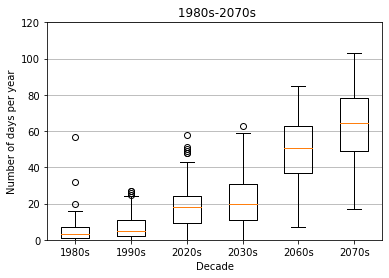

In [103]:
box_cube_decadal(tashot, (1980, 1990, 2020, 2030, 2060, 2070), ylim=120)

<AxesSubplot:title={'center':' 1980s-2070s'}, xlabel='Decade', ylabel='Number of days per year'>

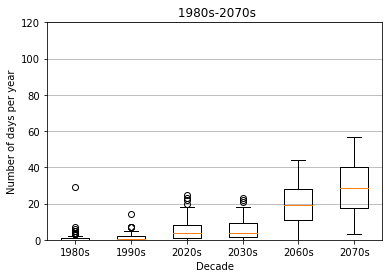

In [120]:
box_cube_decadal(utcihot, (1980, 1990, 2020, 2030, 2060, 2070), ylim=120)

<AxesSubplot:title={'center':' 1980s-2070s'}, xlabel='Decade', ylabel='Number of days per year'>

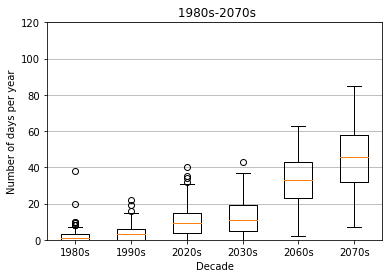

In [124]:
box_cube_decadal(u10hot, (1980, 1990, 2020, 2030, 2060, 2070), ylim=120)

<AxesSubplot:title={'center':' 1980s-2070s'}, xlabel='Decade', ylabel='Number of days per year'>

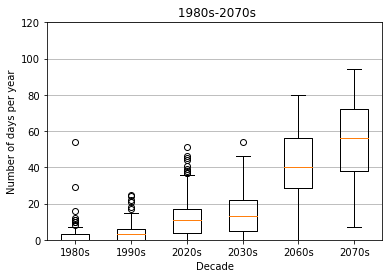

In [101]:
box_df_decadal(tashw, (1980, 1990, 2020, 2030, 2060, 2070), ylim=120)

<AxesSubplot:title={'center':' 1980s-2070s'}, xlabel='Decade', ylabel='Number of days per year'>

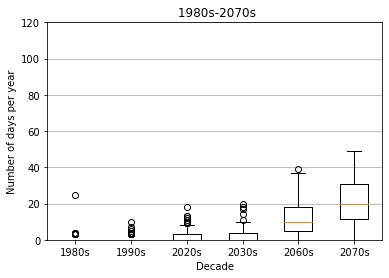

In [125]:
box_df_decadal(utcihw, (1980, 1990, 2020, 2030, 2060, 2070), ylim=120)

<AxesSubplot:title={'center':' 1980s-2070s'}, xlabel='Decade', ylabel='Number of days per year'>

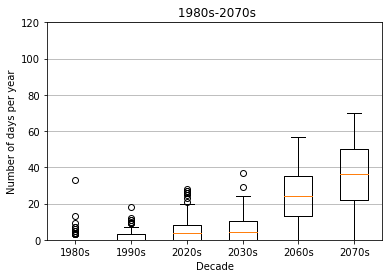

In [126]:
box_df_decadal(u10hw, (1980, 1990, 2020, 2030, 2060, 2070), ylim=120)

# Longest heatwave

In [185]:
def longest_hw(data, **kwargs):
    df = annual_heatwaves(data, **kwargs).melt(id_vars=['year', 'ensemble_member'], var_name='duration', value_name='occurances')
    return df.loc[df.occurances!=0].loc[df.duration==df[df.occurances!=0].duration.max()]

In [195]:
%%time
longest_hw(tasmax, threshold=28, ndays=90)

CPU times: user 2.26 s, sys: 31.6 ms, total: 2.29 s
Wall time: 2.5 s


,year,ensemble_member,duration,occurances
55876,2076,13,73,1


In [197]:
%%time
longest_hw(utci, threshold=28, ndays=90)

CPU times: user 2.18 s, sys: 35.3 ms, total: 2.22 s
Wall time: 2.35 s


,year,ensemble_member,duration,occurances
27908,2080,13,36,1


In [199]:
%%time
longest_hw(u10, threshold=6.0, ndays=90)

CPU times: user 2.16 s, sys: 31.4 ms, total: 2.19 s
Wall time: 2.28 s


,year,ensemble_member,duration,occurances
33956,2080,13,44,1
